In [1]:
import requests

In [2]:
with open("pockstats.key", "r") as f:
    consumer_key = f.readline()

In [3]:
pocket_api = requests.post('https://getpocket.com/v3/oauth/request',
                           data = {'consumer_key': consumer_key,
                                   'redirect_uri': 'PockStats:authorizationFinished'})

code = pocket_api.text.split("=")[1]

In [4]:
import webbrowser

url = "https://getpocket.com/auth/authorize?request_token=" + code + "&redirect_uri=PockStats:authorizationFinished"
webbrowser.open(url)

True

In [5]:
pocket_auth = requests.post('https://getpocket.com/v3/oauth/authorize',
                            data = {'consumer_key': consumer_key,
                                    'code': code})

access_token = pocket_auth.text.split("=")[1].split("&")[0]
username = pocket_auth.text.split("username=")[1]

In [6]:
import psycopg2

try:
    with open("foxan_postgre.conn", "r") as f:
        conn_string = f.readline()
    conn = psycopg2.connect(conn_string)
except:
    print("Unable to connect to the database")

cur = conn.cursor()

insert_statement = "INSERT INTO pocket_user (username) VALUES (%s) ON CONFLICT DO NOTHING;"

cur.execute(insert_statement, (username, ))
total = cur.rowcount
conn.commit()
print("pocket_user: {} row(s) inserted.".format(total))

pocket_user: 0 row(s) inserted.


In [7]:
from pocket import Pocket, PocketException

p = Pocket(
    consumer_key=consumer_key,
    access_token=access_token
)

In [8]:
# retrieves all modified data of the user since last_updated
select_statement = "SELECT last_updated FROM pocket_user WHERE username = %s;"
cur.execute(select_statement, (username, ))

last_updated = cur.fetchone()[0]
modified_data = p.get(since=last_updated, detailType="complete", state="all")

In [9]:
from pprint import pprint
from psycopg2 import sql
# import json

# with open('pocket_data.json', 'w+') as f:
#     f.write(json.dumps(modified_data[0]))

last_updated = modified_data[0]["since"]
data_list = modified_data[0]["list"]

total = 0
insert_statement = sql.SQL("""
INSERT INTO pocket_data ({})
VALUES ({})
ON CONFLICT DO NOTHING;
""")

for item_id, data in data_list.items():
    keys, values = ["username"], [username]
    try:
        for key, value in data.items():
            if key not in ("author", "authors", "image", "images", "video", "videos"):
                keys.append(key)
                values.append(value)

        keys = sql.SQL(', ').join(sql.Identifier(key) for key in keys)
        values = sql.SQL(', ').join(sql.Literal(value) for value in values)
        cur.execute(insert_statement.format(keys, values).as_string(conn))
        total += cur.rowcount
    except psycopg2.Error as e:
        print(cur.mogrify(insert_statement.format(keys, values)).decode("utf-8"))
    
    conn.commit()

print("pocket_data: {} rows inserted.".format(total))

pocket_data: 20 rows inserted.


In [10]:
# update last_updated of user for data extraction next time
update_statement = "UPDATE pocket_user SET last_updated = %s WHERE username = %s;"
cur.execute(update_statement, (last_updated, username))

total = cur.rowcount
conn.commit()
print("pocket_user: {} row(s) updated.".format(total))

pocket_user: 1 row(s) updated.


In [ ]:
words = 0
words2 = ""

for i in archive:
    if 'word_count' in archive[str(i)].keys(): 
        words += int(archive[str(i)]['word_count']) 
    if 'given_title' in archive[str(i)].keys():
        words2 += " " + archive[str(i)]['given_title'].lower()

print("books read: {}".format(words/64000))

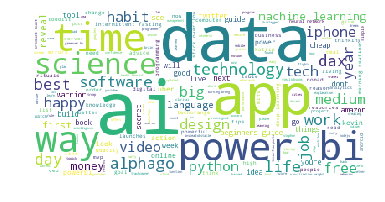

In [12]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

words3 = ""
for char in words2:
    if char in ("abcdefghijklmnopqrstuvwxyz "):
        words3 += char

stopwords = set(STOPWORDS)
nsw = ["inside", "youtube", "google", "facebook", "https", "a16z", "podcast", "lens", "new", "news",
       "one", "thing", "make", "hrs", "take", "az", "vs"]
for i in nsw:
    stopwords.add(i)

wordcloud = WordCloud(stopwords=stopwords, background_color="white")
wordcloud.generate(words3)

plt.imshow(wordcloud)
plt.axis("off")
plt.show()